In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

import numpy as np
import subprocess
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.util import plot_reduction_errors
from scalecast.SeriesTransformer import SeriesTransformer
from scalecast.auxmodels import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = (
    pd.read_csv("../data/air_passengers.csv", parse_dates=['date'])
    .rename({'date': 'month'}, axis=1)
    .set_index('month')
    .sort_index()
)
data.head()

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [28]:
start_date, end_date = min(data.index), max(data.index)
all_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
print(len(all_dates))
print(data.shape[0])
print(data.isna().sum())

144
144
passengers    0
dtype: int64


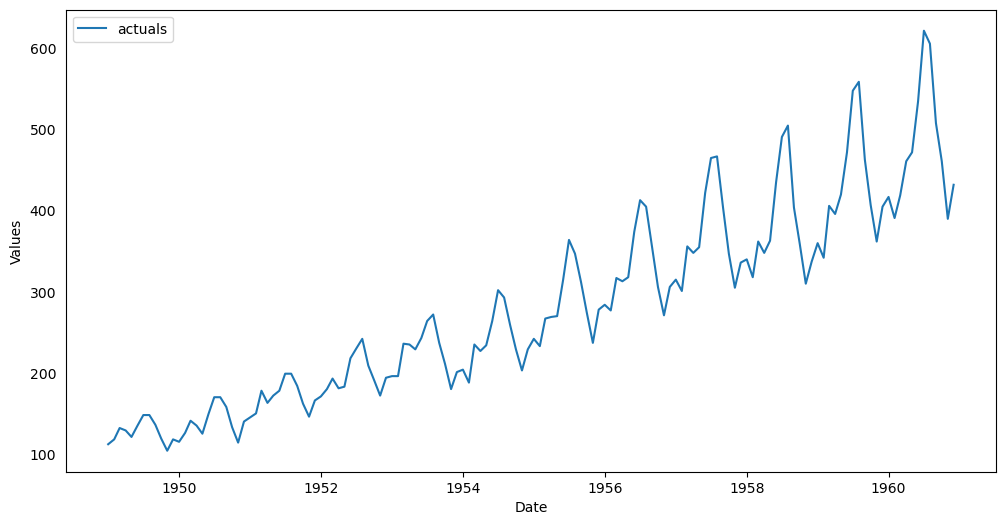

In [43]:
f = Forecaster(
    y = data['passengers'],
    current_dates=data.index,
    future_dates=12,
    test_length=.2,
    # metrics = ['rmse','mae','mape','r2'],
    cis = True
)
f.plot();

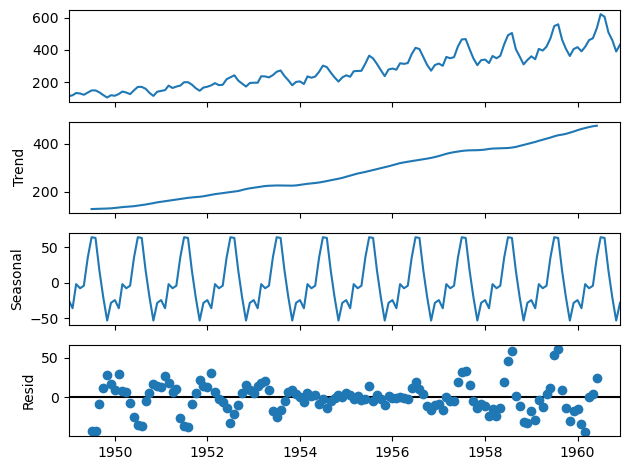

In [34]:
f.seasonal_decompose().plot();

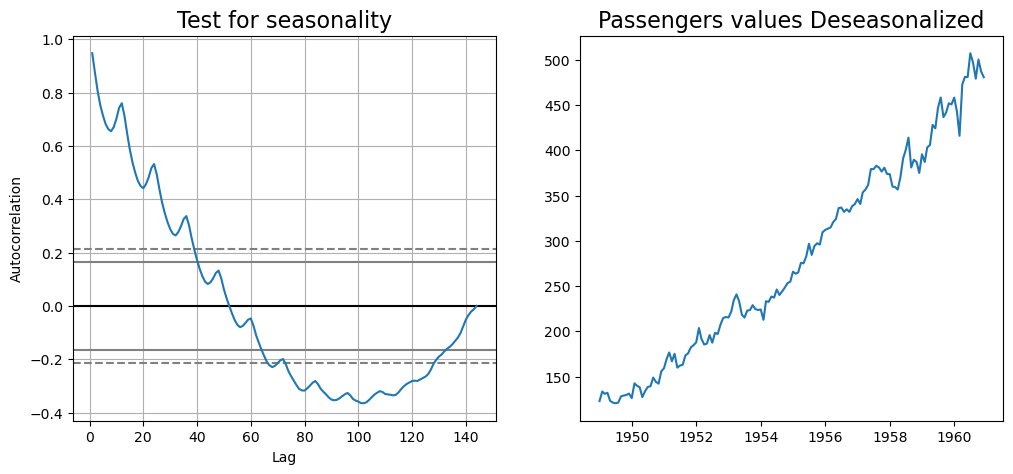

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("Test for seasonality", fontsize=16)
autocorrelation_plot(data['passengers'].tolist(), ax=ax1)

additive_decomposition = seasonal_decompose(data['passengers'], model="multiplicative", period=12)
deseasonalized = data['passengers'].values / additive_decomposition.seasonal

ax2.plot(deseasonalized)
ax2.set_title('Passengers values Deseasonalized', fontsize=16);

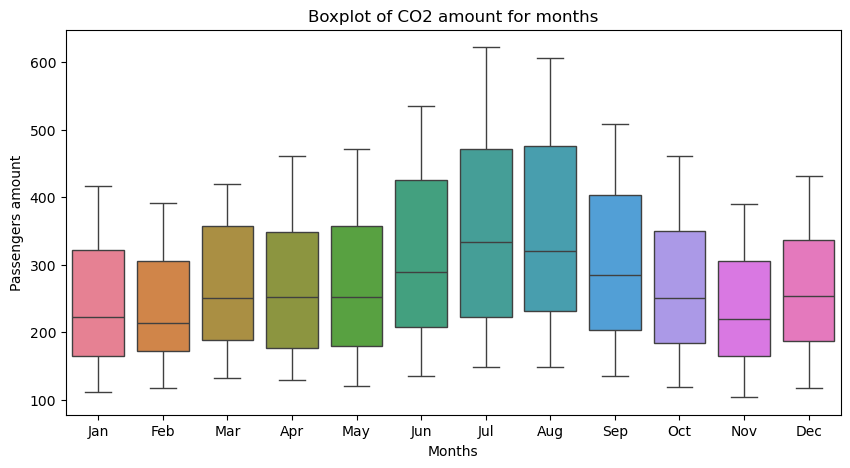

In [37]:
data_with_month_number = data.reset_index().assign(month_name = lambda x: x['month'].astype("datetime64[ns]").dt.strftime("%b"))
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel("Months")
ax.set_ylabel("Passengers amount")
ax.set_title("Boxplot of CO2 amount for months")
sns.boxplot(data=data_with_month_number[["month_name", "passengers"]], x='month_name', y ="passengers", ax=ax, hue='month_name');

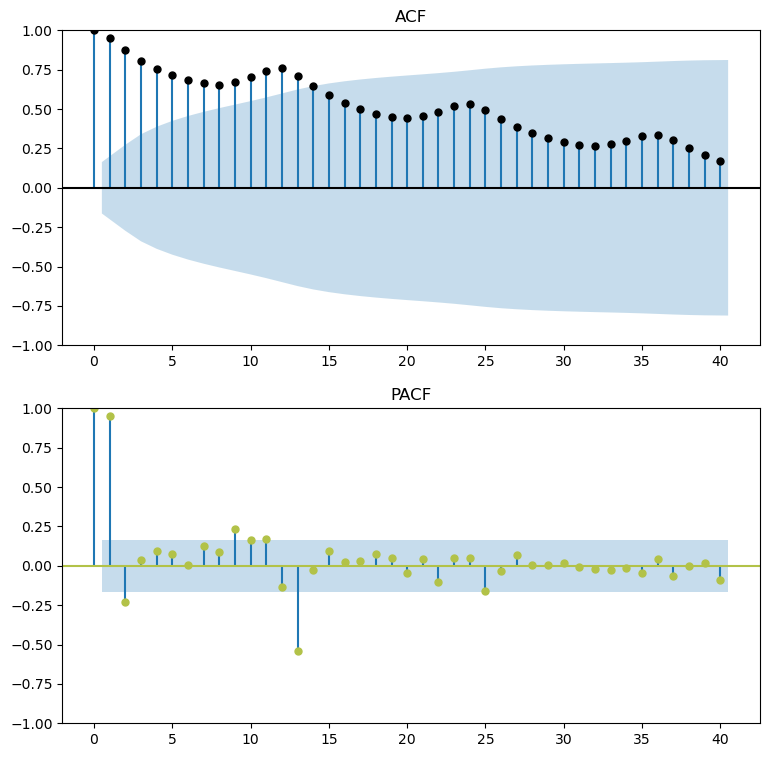

In [5]:
figs, (ax1, ax2) = plt.subplots(2, 1,figsize=(9,9))
f.plot_acf(ax=ax1, title='ACF', lags=40, color='black')
f.plot_pacf(ax=ax2, title='PACF', lags=40, color='#B2C248', method='ywm')
plt.show();

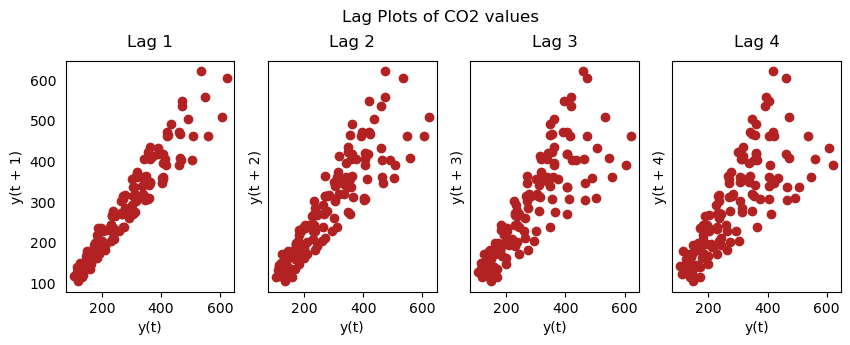

In [7]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(data['passengers'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of CO2 values', y=1.05)    
plt.show()

In [8]:
adf, pval, usedlag, nobs, crit_vals, icbest = f.adf_test(full_res=True)
print('ADF test statistic: ', adf)
print('ADF p-value: ', pval)
print('Number of lags used: ', usedlag)
print('Number of observations: ', nobs)
print('Critical values: ', crit_vals)
print('Best information criterion: ', icbest)

ADF test statistic:  0.8153688792060456
ADF p-value:  0.991880243437641
Number of lags used:  13
Number of observations:  130
Critical values:  {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Best information criterion:  996.6929308390189


<AxesSubplot: xlabel='Date', ylabel='Values'>

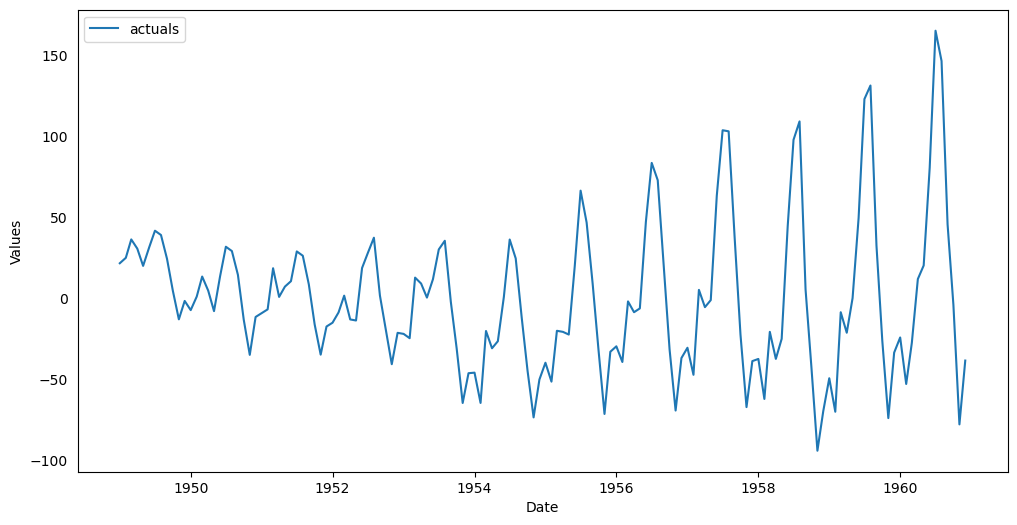

In [9]:
transformer = SeriesTransformer(f)
f_detrended = transformer.DetrendTransform(m=12)
f_detrended.plot()

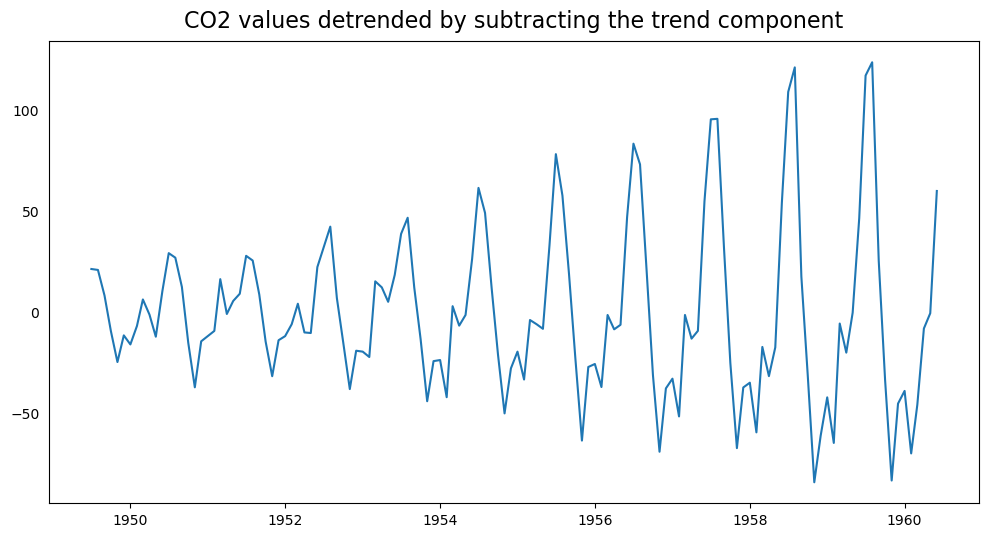

In [11]:
additive_decomposition = seasonal_decompose(data['passengers'], model="additive", period=12)
detrended = data["passengers"].values - additive_decomposition.trend

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(detrended)
plt.title('CO2 values detrended by subtracting the trend component', fontsize=16);

# Forecasting

In [44]:
f.add_time_trend()
f.add_seasonal_regressors('year', raw=False, sincos=True)
f.auto_Xvar_select(cross_validate=True) # find best look-back, trend, and seasonality for your series

# Tell the Object to Evaluate Confidence Intervals
f.eval_cis(mode = True, cilevel = .95)

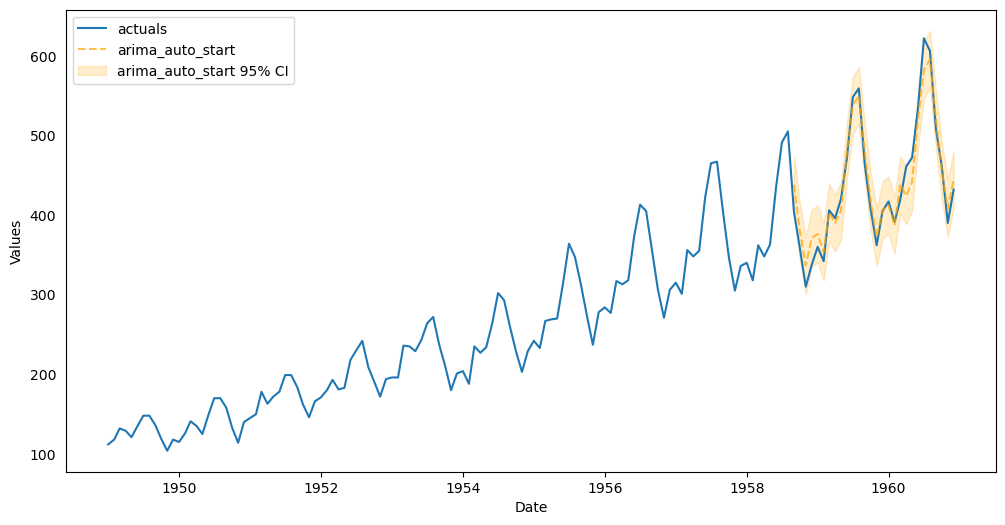

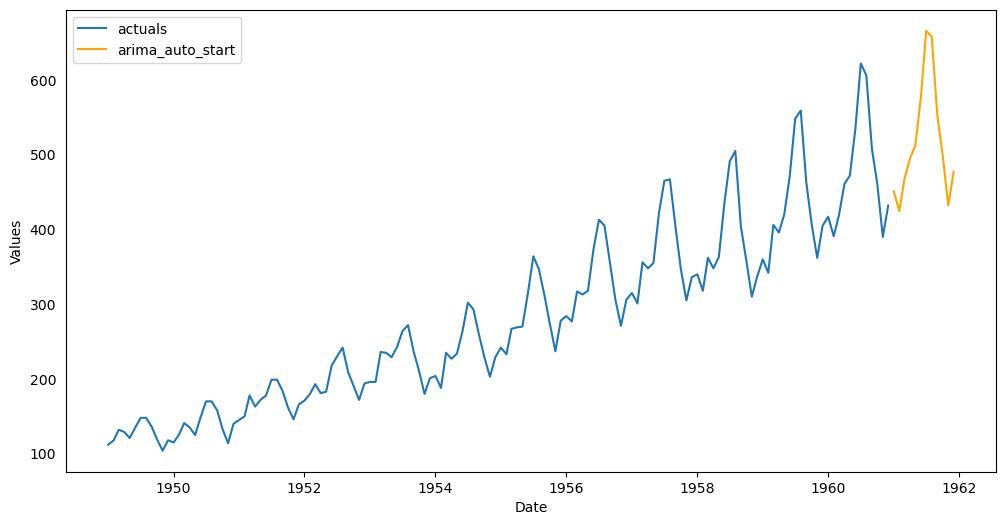

In [38]:
f.set_estimator('arima') # select an estimator
f.cross_validate(k=3) # tune model hyperparams using time series cross validation
f.auto_forecast(call_me="arima_auto_f") # automatically forecast with the chosen Xvars and hyperparams

results = f.export(['lvl_fcsts','model_summaries']) # extract results
f.plot_test_set(ci=True, models=['arima_auto_f'])
f.plot(models=['arima_auto_f']);

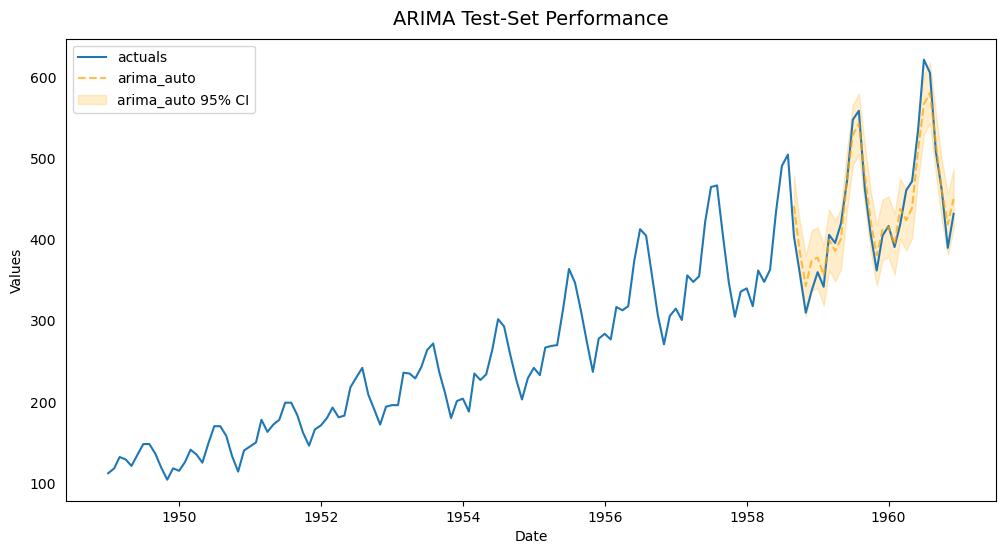

<AxesSubplot: xlabel='Date', ylabel='Values'>

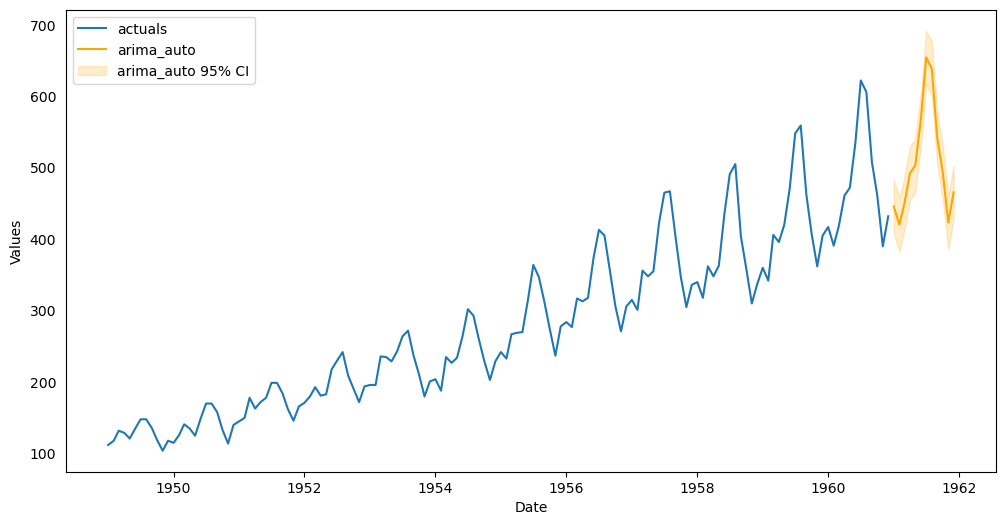

In [36]:
auto_arima(f, m=12, call_me='arima_auto')
f.plot_test_set(ci=True,models='arima_auto')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()
f.plot(models=['arima_auto'], ci=True)

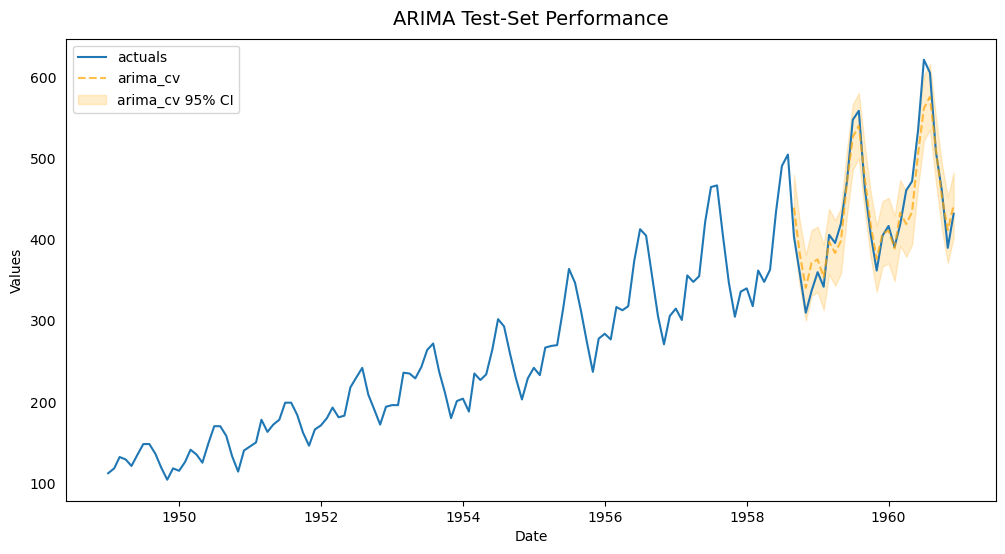

<AxesSubplot: xlabel='Date', ylabel='Values'>

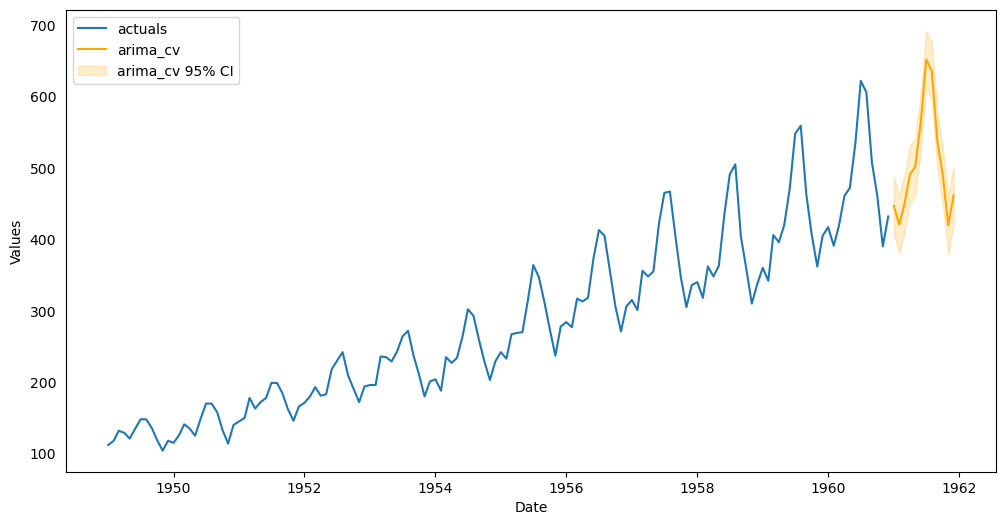

In [35]:
f.set_estimator('arima') # select an estimator
f.set_validation_length(12)
grid = {
    'order':[
        (1,1,1),
        (1,1,0),
        (0,1,1),
    ],
    'seasonal_order':[
        (2,1,1,12),
        (1,1,1,12),
        (2,1,0,12),
        (0,1,0,12),
    ],
}

f.ingest_grid(grid)
f.tune()
f.auto_forecast(call_me="arima_cv")
f.plot_test_set(ci=True, models=['arima_cv'])
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()
f.plot(ci=True,models='arima_cv')

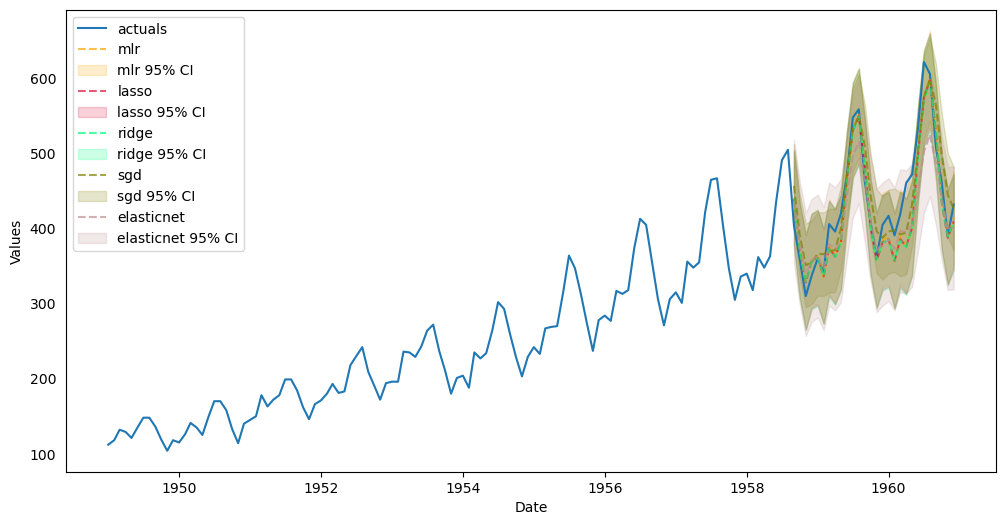

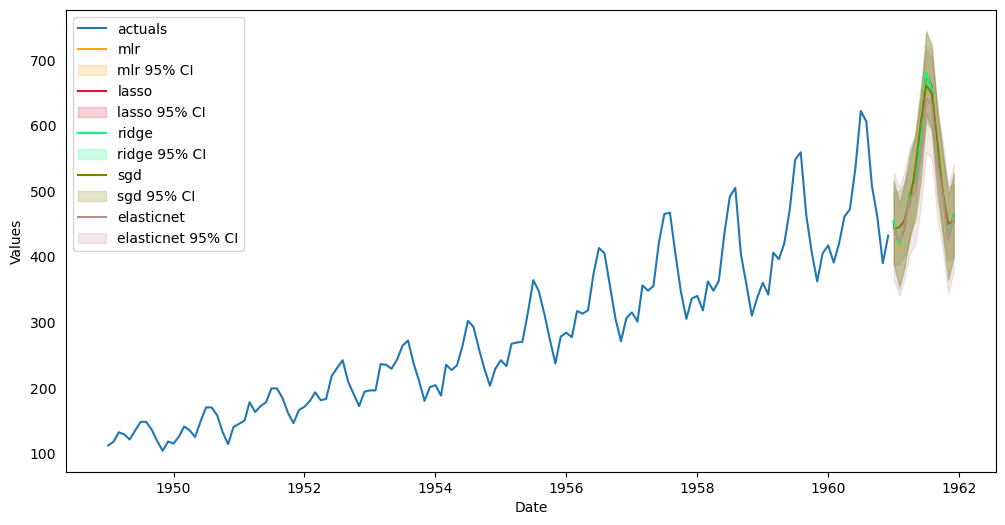

In [40]:
linear_sklearn_models=['mlr', 'lasso','ridge','elasticnet','sgd']

for model in linear_sklearn_models:
    f.set_estimator(model)
    f.cross_validate(k=5) # tune model hyperparams using time series cross validation
    f.auto_forecast() # automatically forecast with the chosen Xvars and hyperparams

f.plot_test_set(ci=True, models=linear_sklearn_models ,order_by='TestSetRMSE');
f.plot(ci=True,models=linear_sklearn_models,order_by='TestSetRMSE')
plt.show();

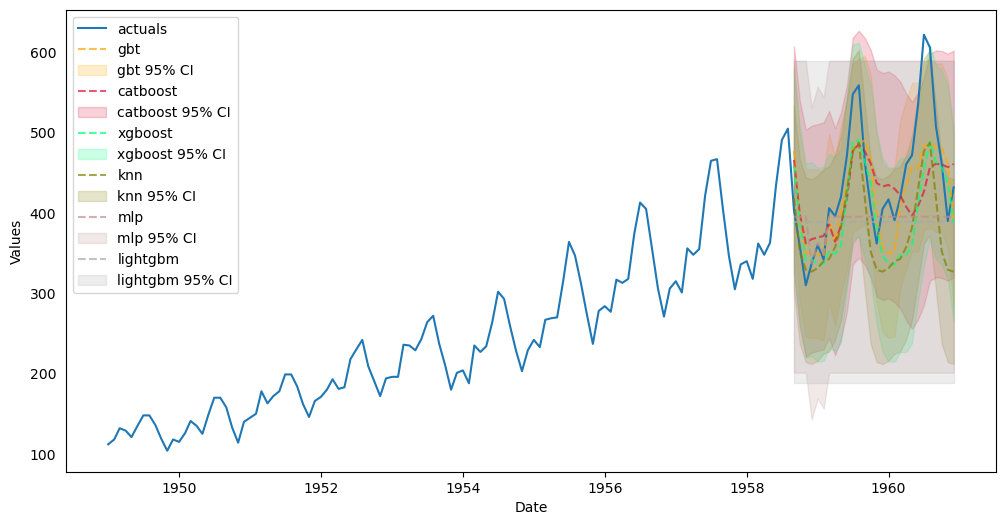

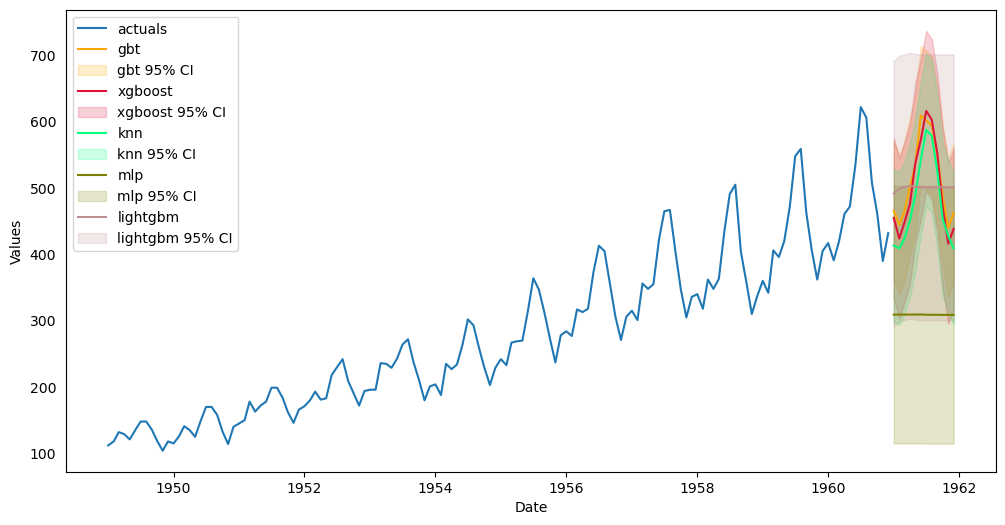

In [41]:
non_linear_sklearn_models = ['gbt','xgboost','lightgbm','catboost','knn', 'mlp']

for model in non_linear_sklearn_models:
    f.set_estimator(model)
    f.cross_validate(k=5) # tune model hyperparams using time series cross validation
    f.auto_forecast() # automatically forecast with the chosen Xvars and hyperparams

f.plot_test_set(ci=True, models=['gbt','xgboost','lightgbm','catboost','knn', 'mlp'], order_by='TestSetRMSE')
f.plot(ci=True,models=['rf','gbt','xgboost','lightgbm','knn','mlp'],order_by='TestSetRMSE')
plt.show()

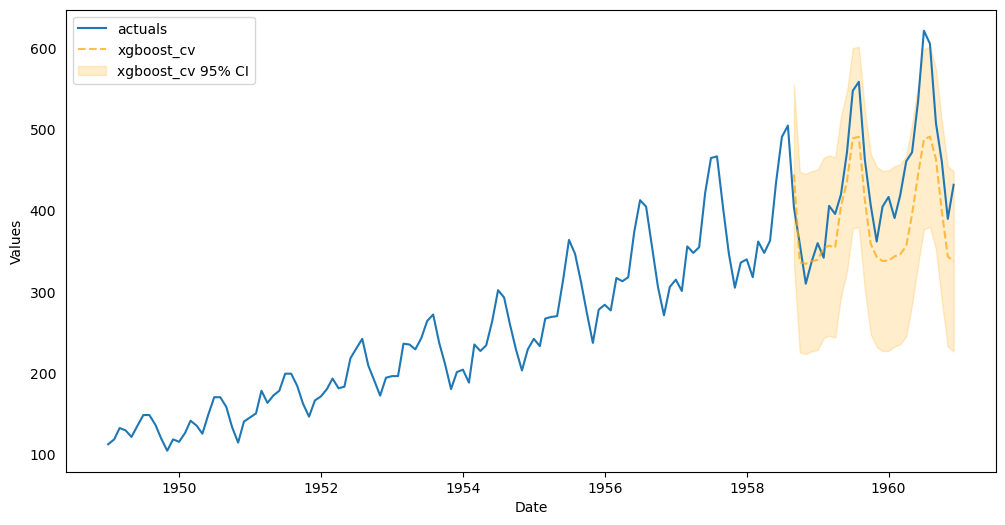

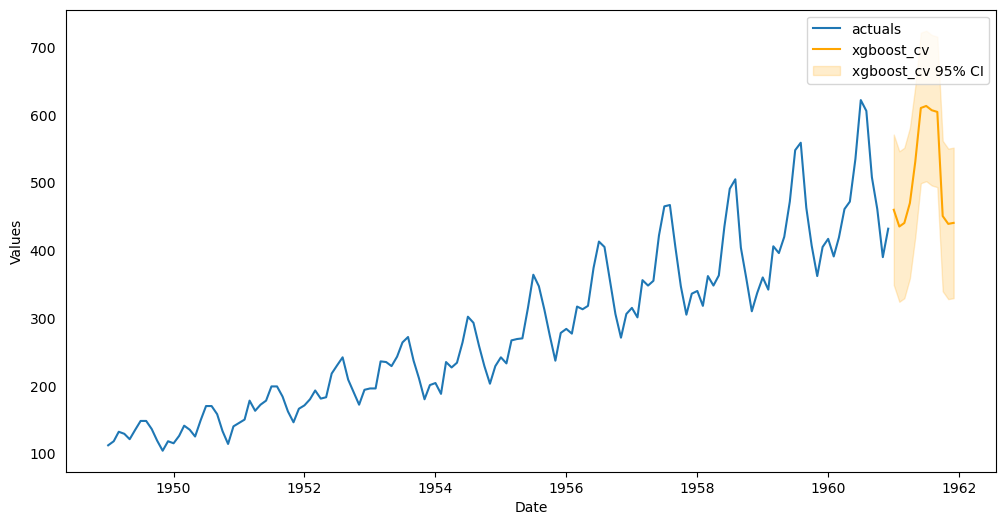

In [45]:
f.set_estimator('xgboost')
xgboost_grid = {
     'n_estimators':[150,200,250, 500],
     'scale_pos_weight':[5,10],
     'learning_rate':[0.1,0.2, 0.5],
     'gamma':[0,3,5],
     'subsample':[0.8,0.9]
}
f.ingest_grid(xgboost_grid)
# f.auto_Xvar_select(cross_validate=True, estimator='xgboost', trend_estimator='xgboost')
# f.auto_Xvar_select(cross_validate=True)
f.cross_validate(k=5, dynamic_tuning=True)
f.auto_forecast(call_me='xgboost_cv')

f.plot_test_set(ci=True, models='xgboost_cv')
f.plot(ci=True,models='xgboost_cv')
plt.show()